## [Enzo LOUIS]
## [Recherche personnage]

**Objectif : repérer la centralité du personnage au travers des saisons : à quel point Phoebe est-elle intégré au groupe d'amis, de façon équitable ? Quel évènement font qu'un personnage parle moins à un autre (déménagement, séparation), repérer les saisons où le groupe est le plus unis via la centralité des 6 personnages**

*Interprétation (dans l'interface) mise en lien avec l'analyse d'émotion et la mise en avant des personnages*

**Définitions :**
- réplique

    *Ross: Salut Rachel*

    *Rachel: Salut Ross*
    
    1 réplique pour Rachel, 1 réplique pour Ross
- mentions

    *Exemple de "mentions"* :
    Ross: Salut Monica, comment vas-tu ?
    Monica: Salut Ross, j'ai vu Joey aujourd'hui, je ne vais pas bien.

    Monica, Ross et Joey ont ici été mentionné 1 fois chacun (ça montre l'importance accordé entre chacun des personnages, même si ils sont loin)

### Setup

In [6]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns

from collections import Counter
from scipy.stats import zscore

df = pd.read_csv("../Analyse_Sentiments/friends_dialogues_final.csv", encoding='utf-8')

def clean_line(line):
    """
    Enlève les annotations/didascalies, les ensemble de mots entre parenthèses
    Mets en minuscule
    Enlève les caractères spéciaux
    Split la ligne en mots
    :param line: réplique de dialogue
    :return: liste de mots
    """
    line = re.sub(r'\([^)]*\)', '', line)
    # lower + clean special char + split
    return re.sub(r'[^\w\s]', '', line.lower()).split()

PATH = "../../src/main/resources/les_png/graphe_orienté_mentions_entre_personnages"

### Mention entre personnage sur toute la série

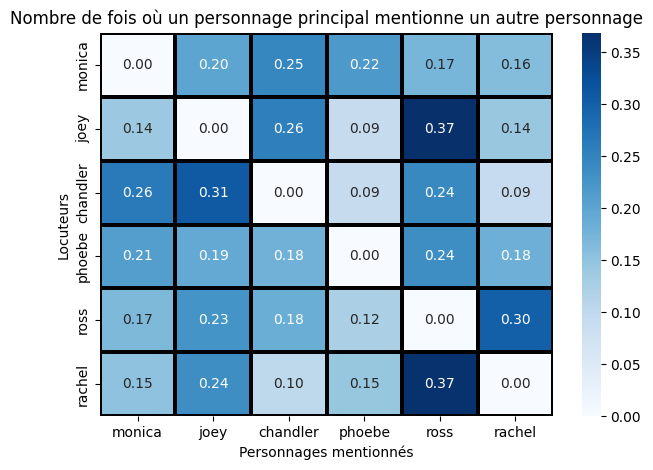

In [ ]:
mentions_by_character = { 'monica': [], 'joey': [], 'chandler': [], 'phoebe': [], 'ross': [], 'rachel': [] }

# Etude des mentions entre personnages, qui mentionne le plus qui
# Nettoyage + Filtre : on garde tous les mots étant des noms des 6 personnages principaux
for _, row in df.iterrows():
    character = row['character'].lower()
    line = row['line']
    
    if character in mentions_by_character:  # Vérifier si le personnage est l'un des 6 principaux
        words = clean_line(line)  # Nettoyer et diviser la ligne en mots
        mentioned_character = [word for word in words if word in mentions_by_character.keys()]
        mentions_by_character[character].extend(mentioned_character)  # Ajouter les mots au personnage

mentions_stats = mentions_by_character.copy()
for character, mentions in mentions_by_character.items():
    mention_counts = Counter(mentions) # Compter les occurrences des mentions
    mention_counts[character] = 0
    mentions_stats[character] = mention_counts.most_common()  # Récupérer les 10 mots les plus fréquents
# Créer un DataFrame à partir des statistiques de mentions
mentions_df = pd.DataFrame(mentions_stats).T
mentions_df = mentions_df.fillna(0)  # Remplacer les NaN par 0

def generer_heatmap_global_mentions_personnage():
    # Transformation en DataFrame
    df = pd.DataFrame({
        speaker: dict(mentions) for speaker, mentions in mentions_stats.items()
    }).T # transposé pour avoir les personnages speaker en lignes

    # ordonne la heatmap comme mentions_by_character au-dessus
    df = df[list(mentions_by_character)]
    df_ponderee = df.div(df.sum(axis=1), axis=0)

    sns.heatmap(df_ponderee, annot=True, fmt='.2f', cmap='Blues', cbar=True, linewidths=1.5, linecolor='black')
    plt.title("Nombre de fois où un personnage principal mentionne un autre personnage")
    plt.xlabel("Personnages mentionnés")
    plt.ylabel("Locuteurs")
    plt.tight_layout()
    # sauvegarde en png
    # plt.savefig("heatmap_mentions_personnages.png", dpi=300)
    plt.show()

generer_heatmap_global_mentions_personnage()

In [8]:
def taux_equilibre(distribution):
    """
    distribution : dict ou list
    
    Retourne le taux d'équilibre en %, basé sur l'indice de Gini inversé
    (100% = équilibre parfait, 0% = un seul poids domine)
    utilisé pour évaluer l'équilibre des mentions entre personnages.
    """
    if isinstance(distribution, dict):
        weights = np.array(list(distribution.values()))
    else:
        weights = np.array(distribution)
    
    # normalisation (pour avoir une somme de 1 si pas déjà fait)
    weights = weights / weights.sum()
    
    # tri croissant
    sorted_weights = np.sort(weights)
    n = len(weights)
    
    # Calcul Gini
    cum_weights = np.cumsum(sorted_weights)
    gini = (n + 1 - 2 * np.sum(cum_weights) / cum_weights[-1]) / n
    
    # Inverse du Gini (car Gini=0 égalité parfaite, Gini=1 inégalité totale)
    taux = (1 - gini) * 100
    
    return taux

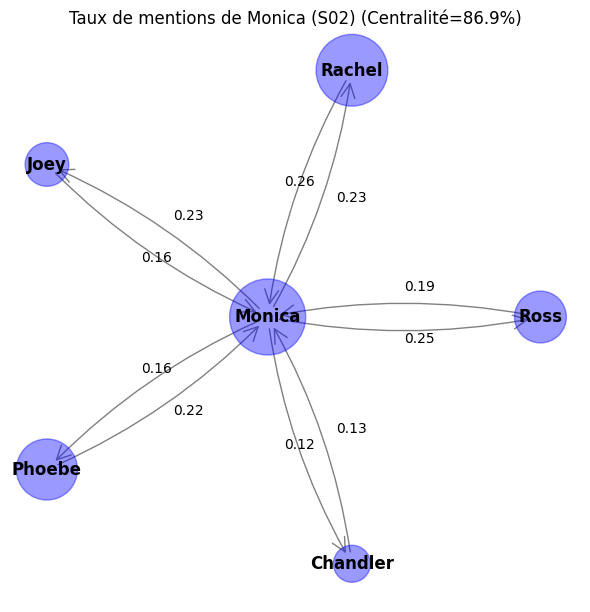

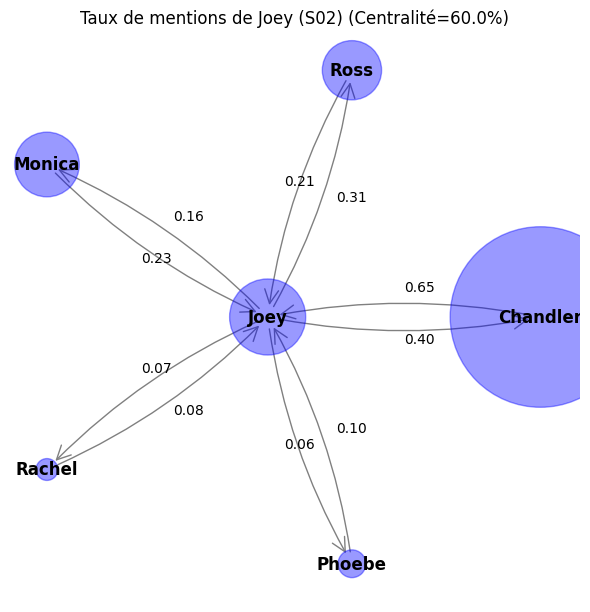

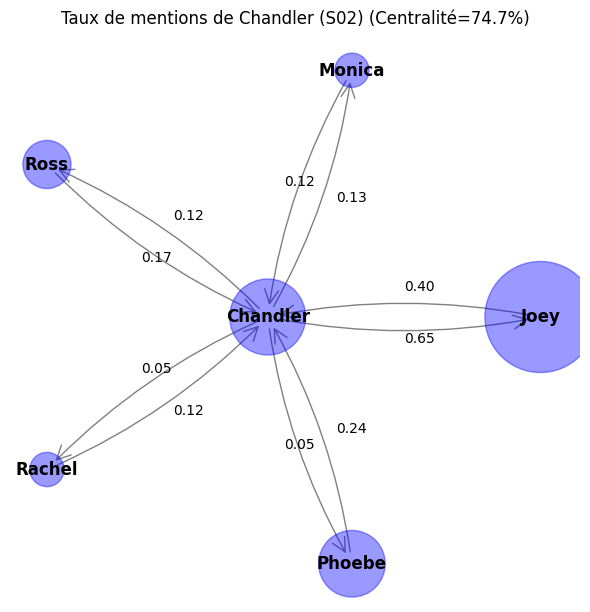

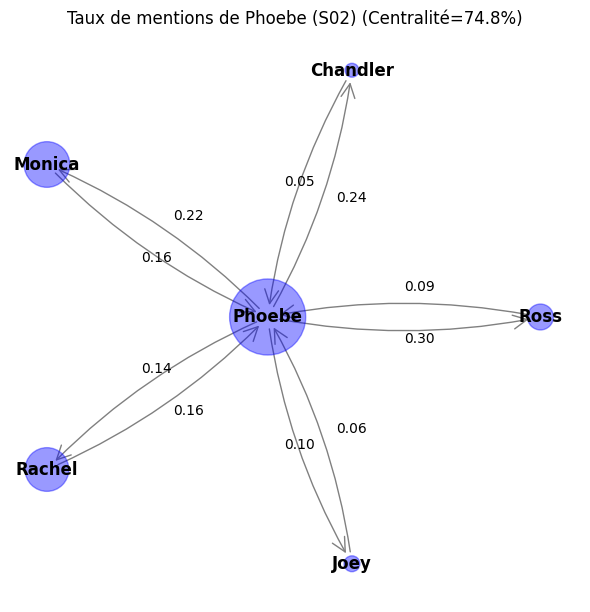

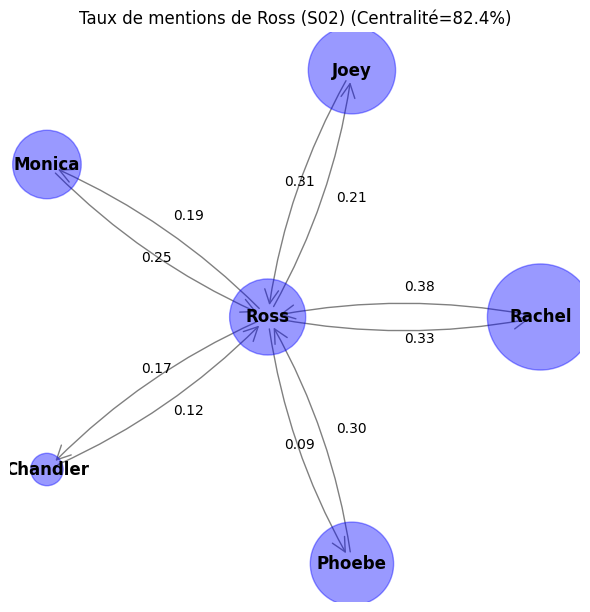

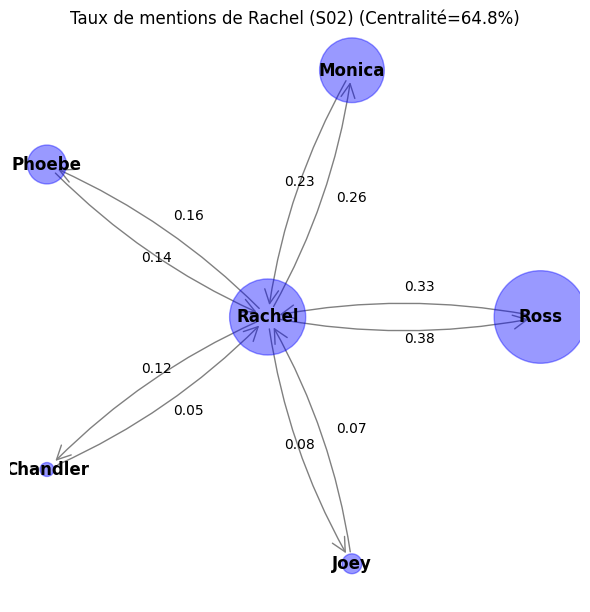

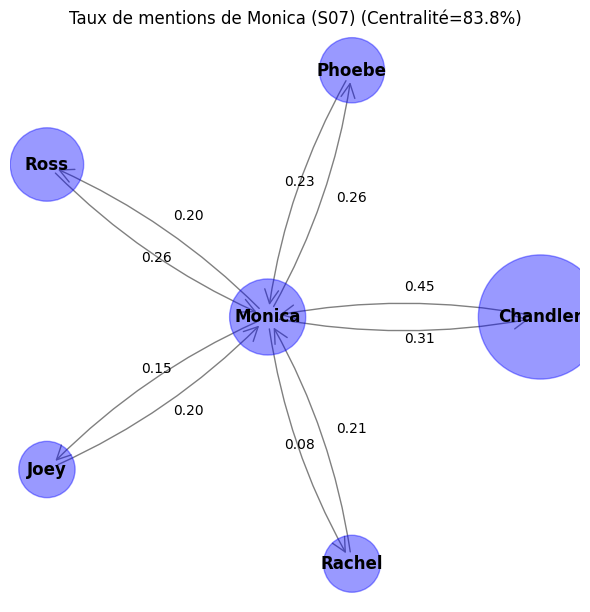

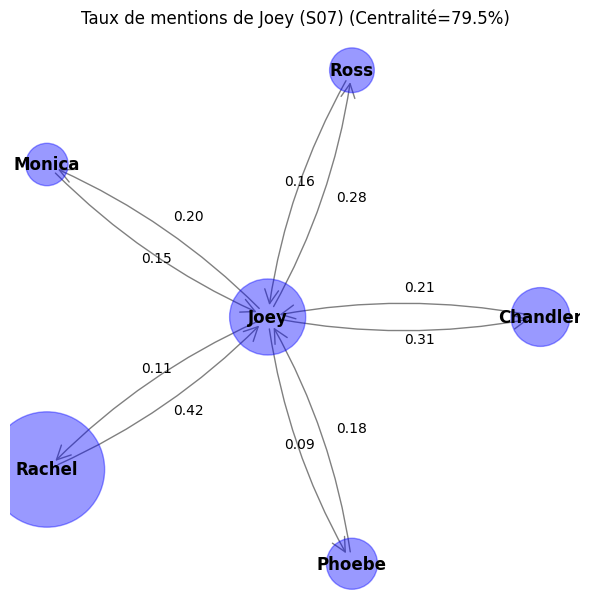

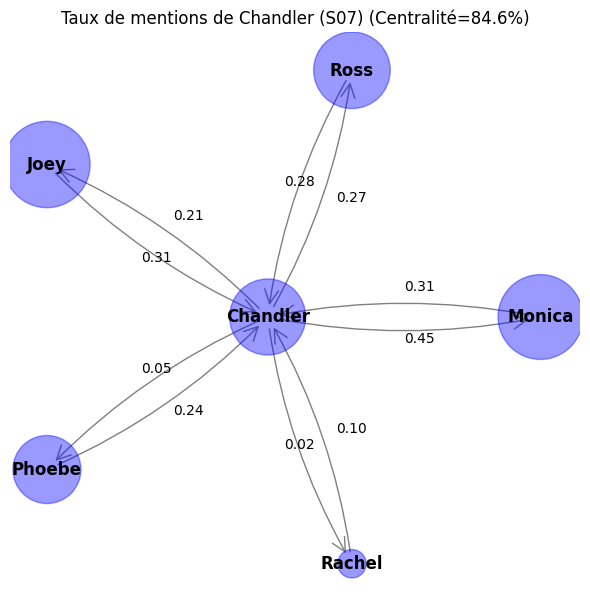

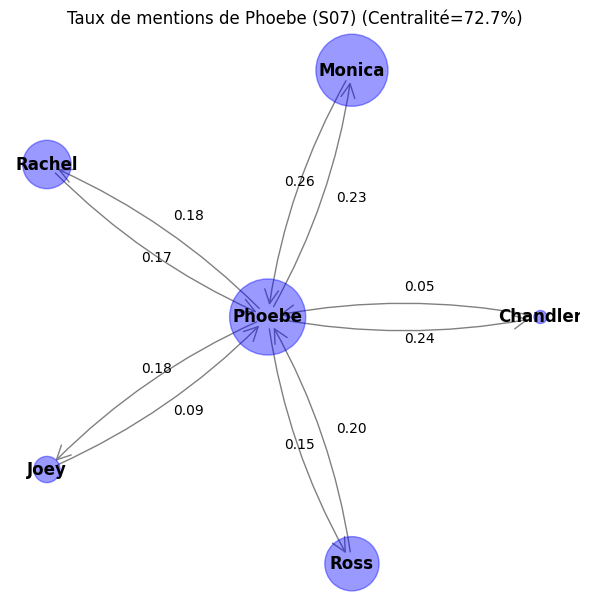

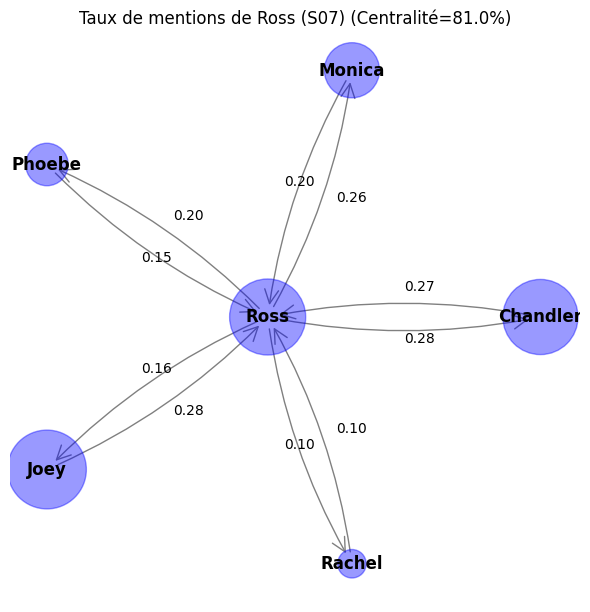

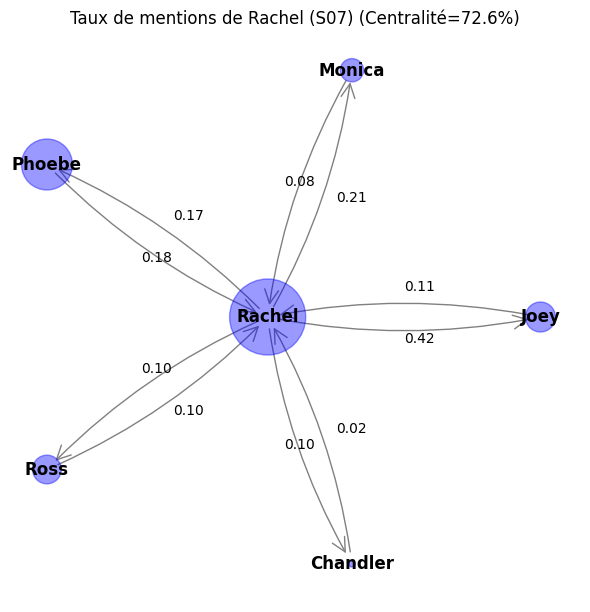

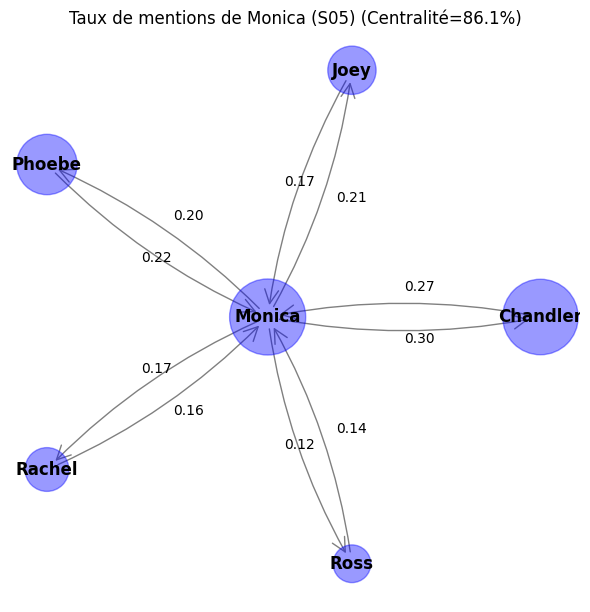

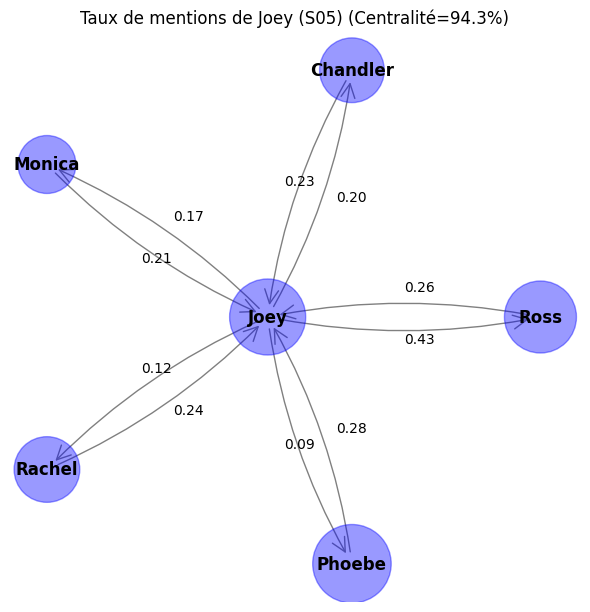

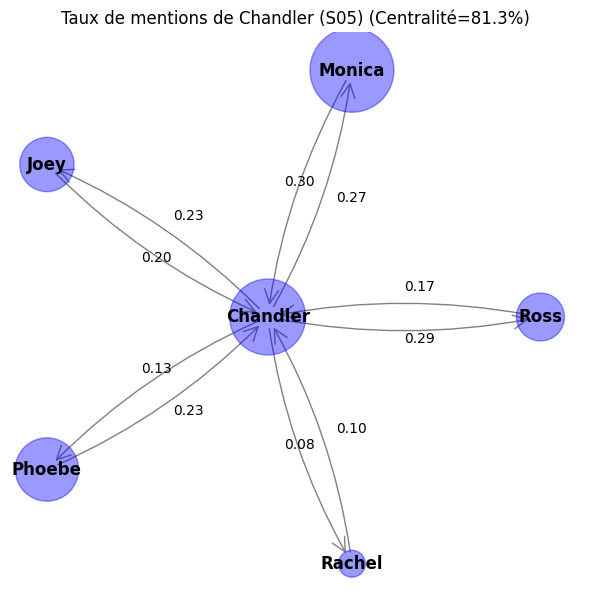

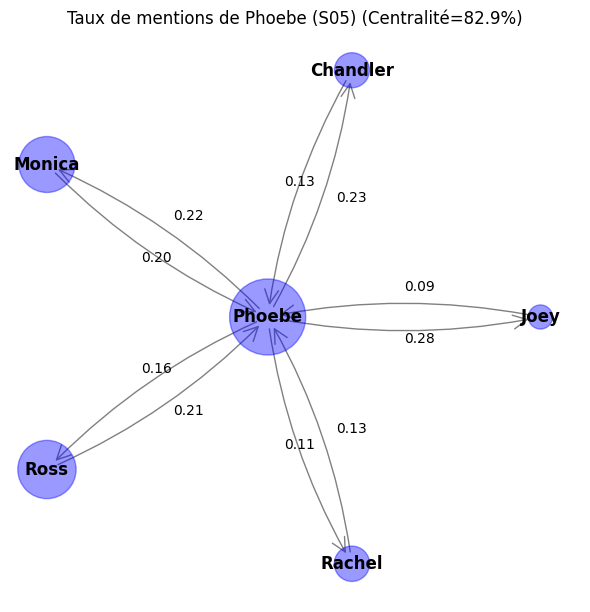

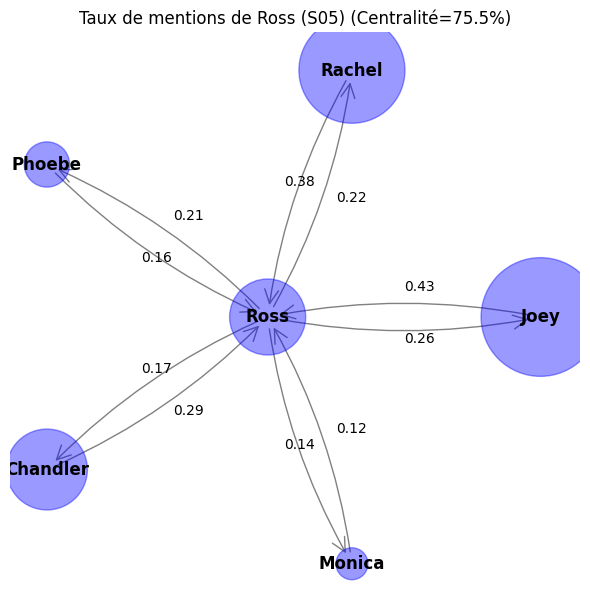

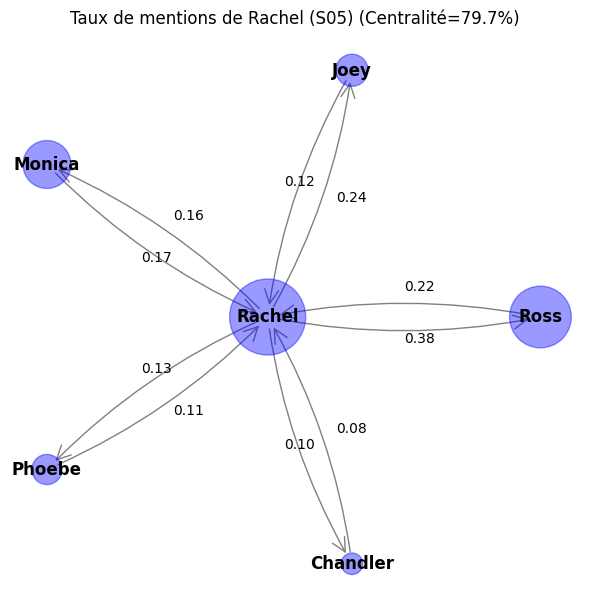

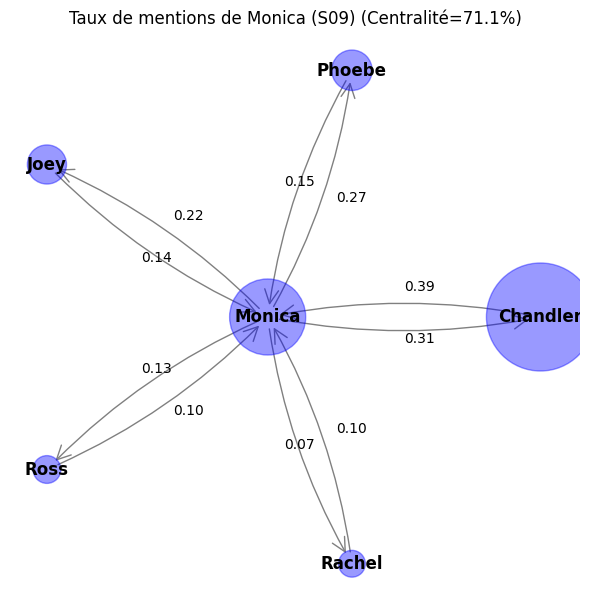

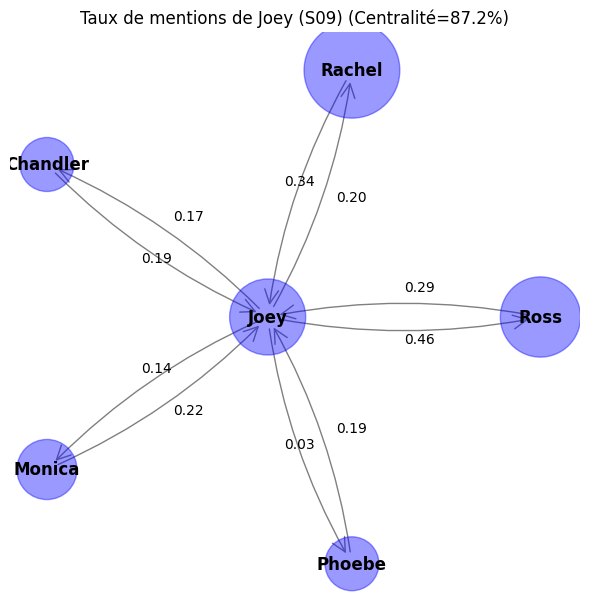

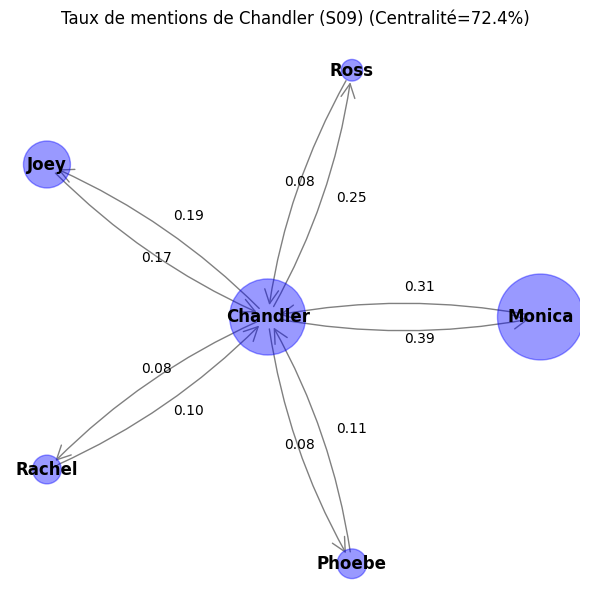

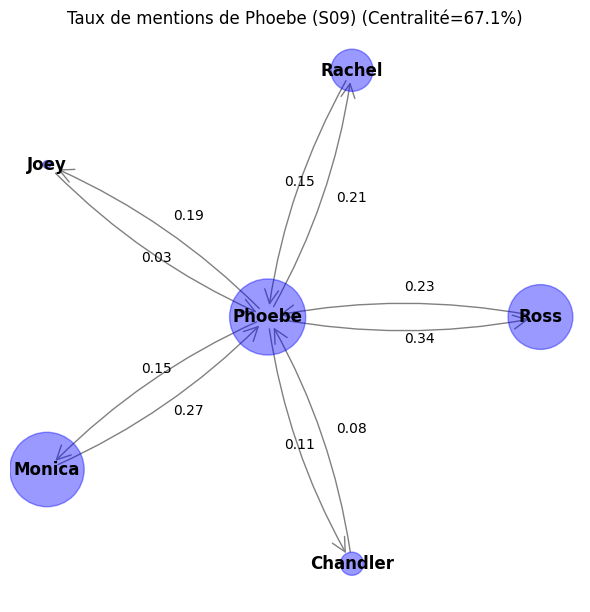

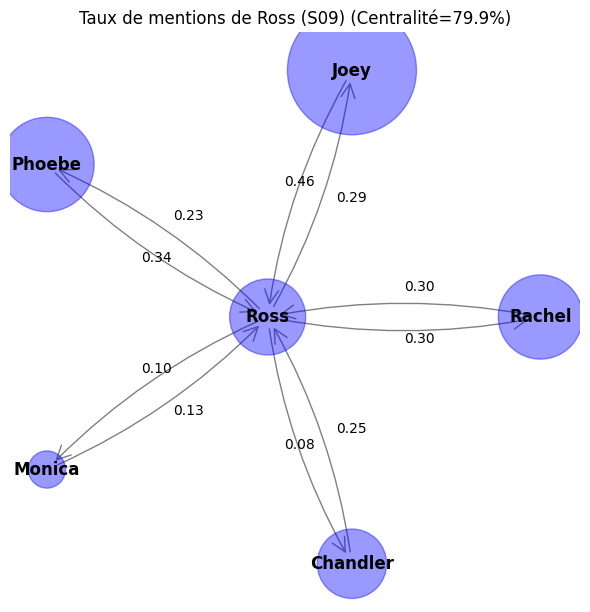

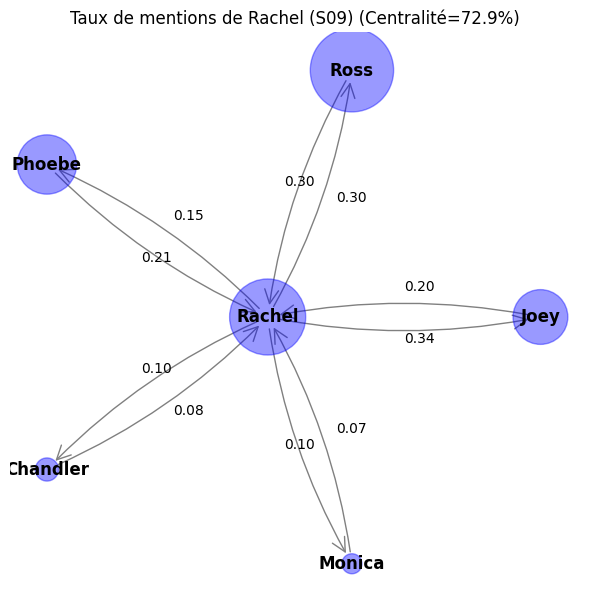

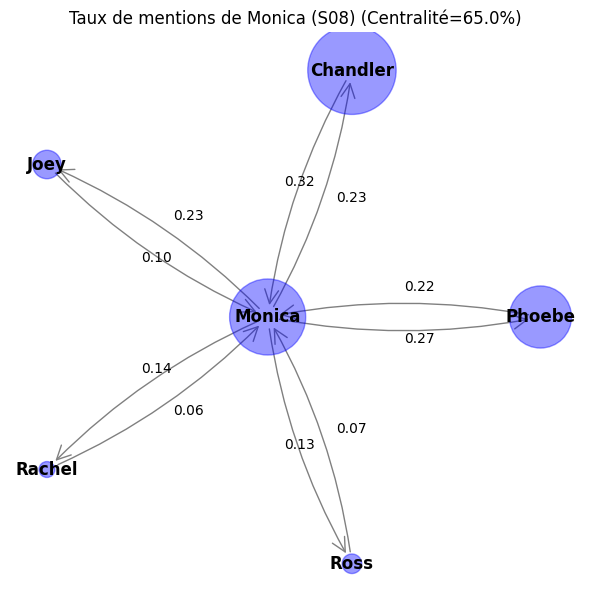

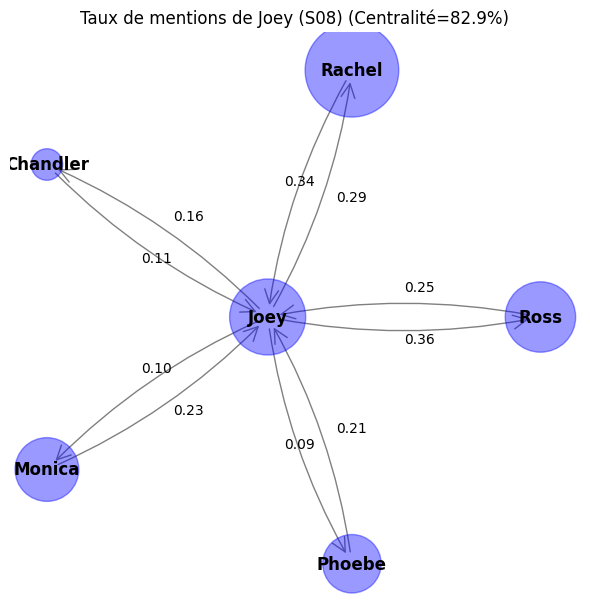

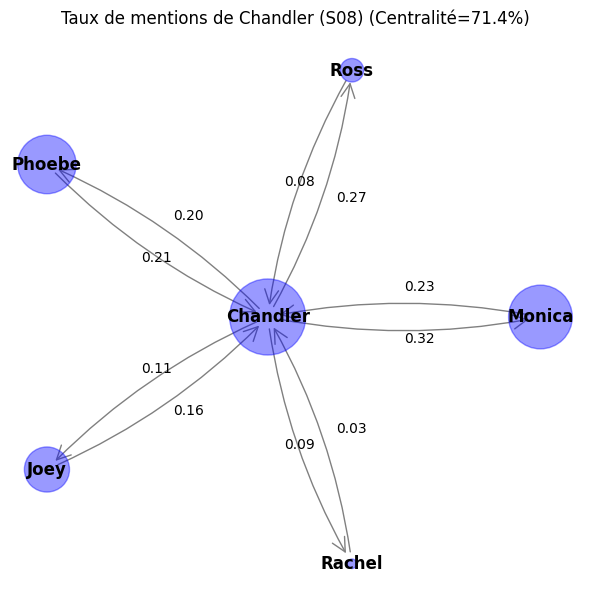

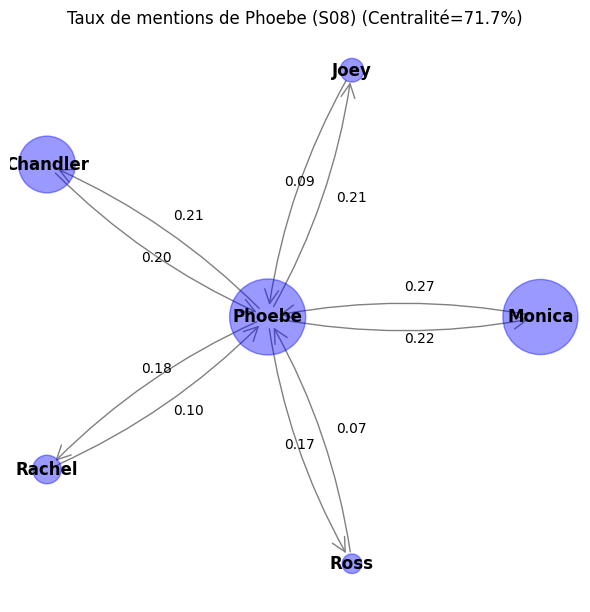

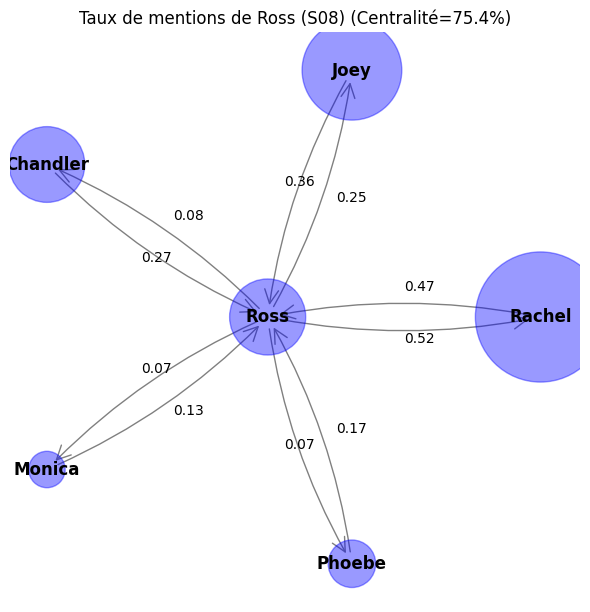

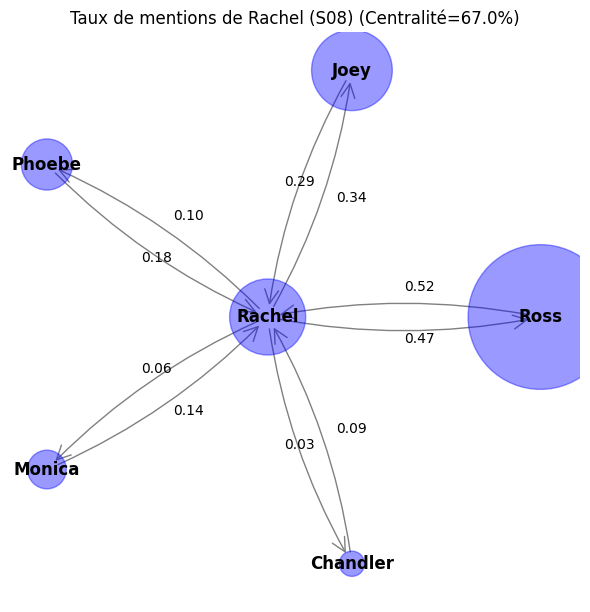

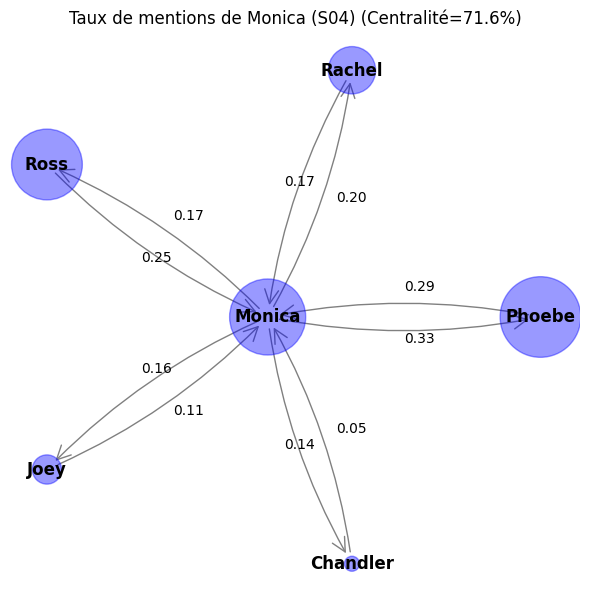

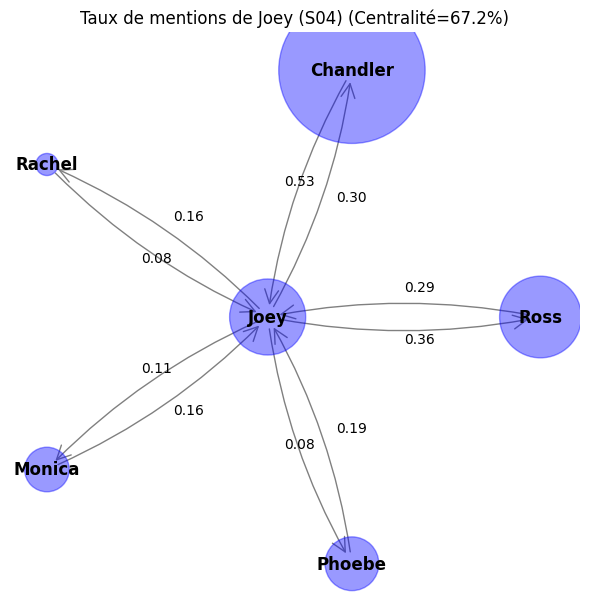

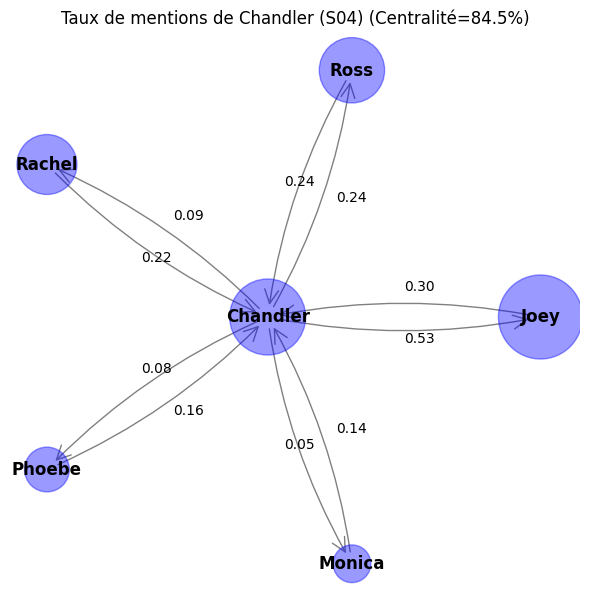

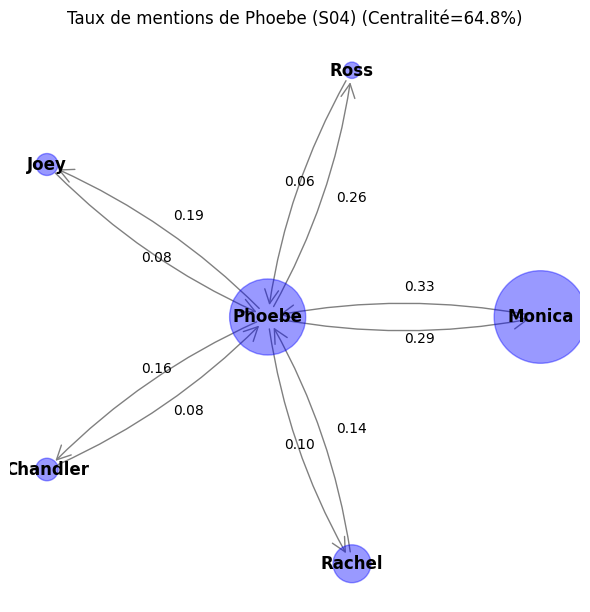

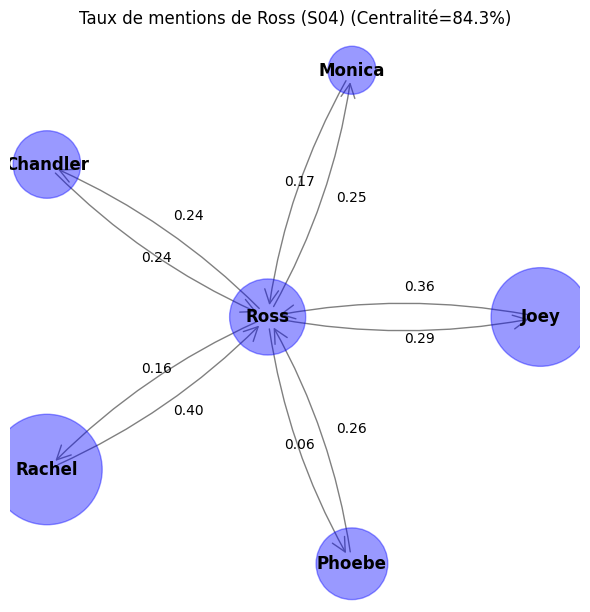

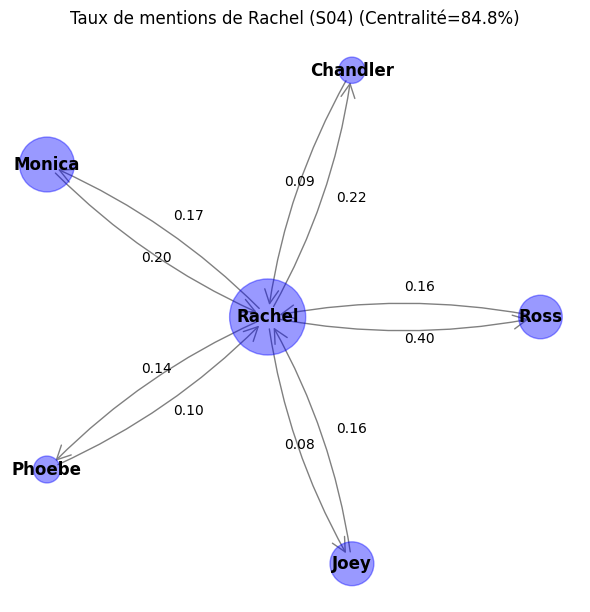

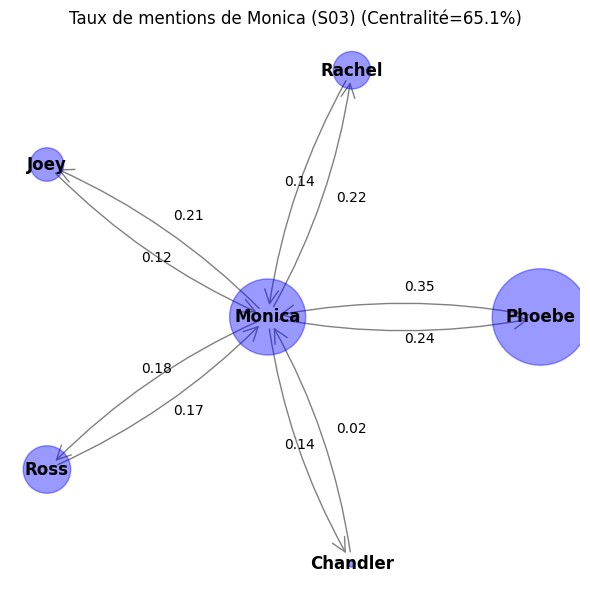

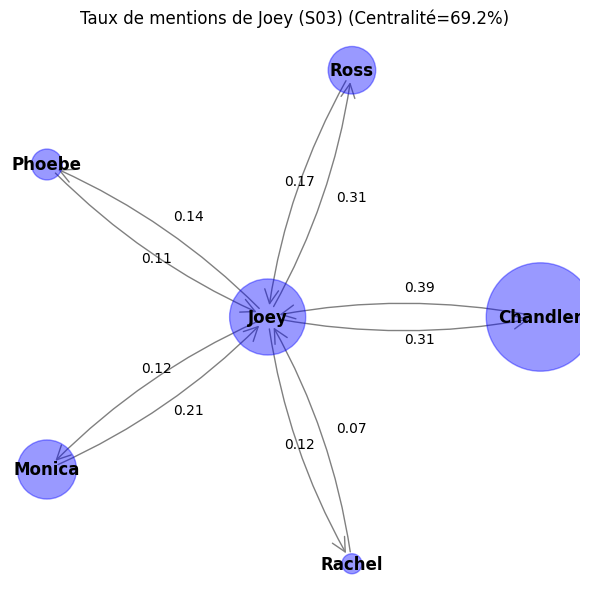

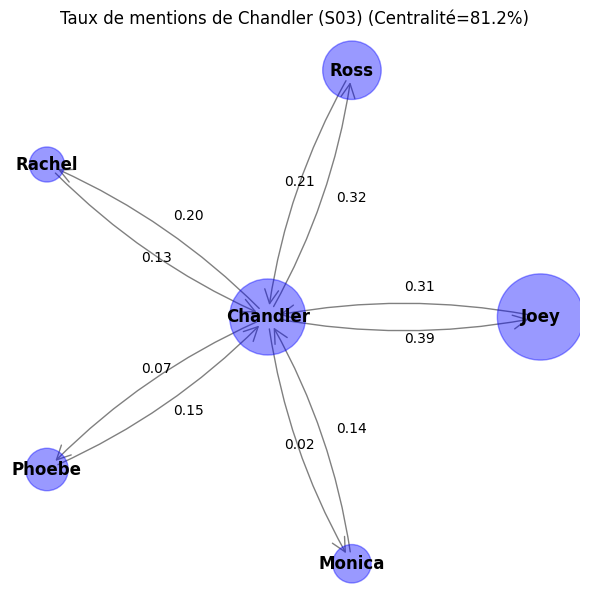

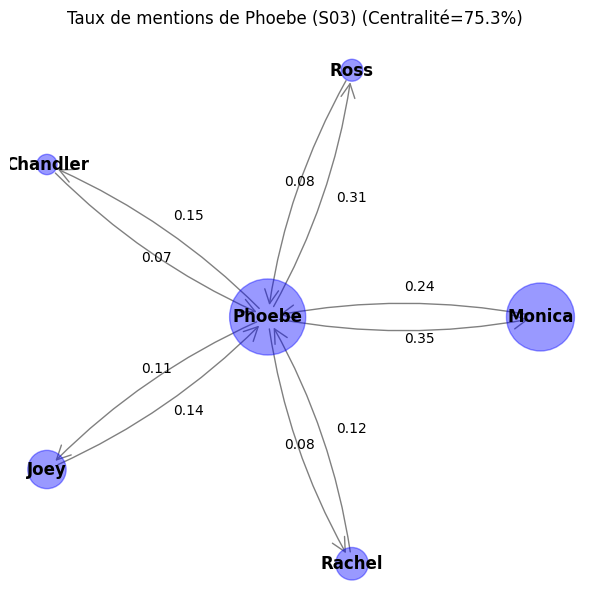

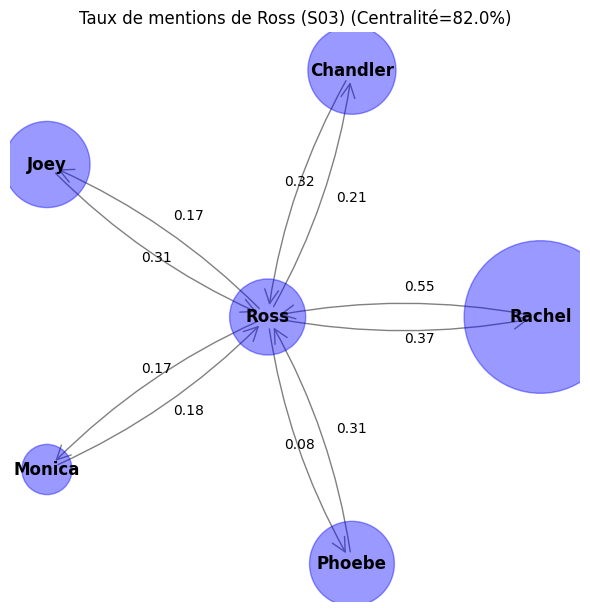

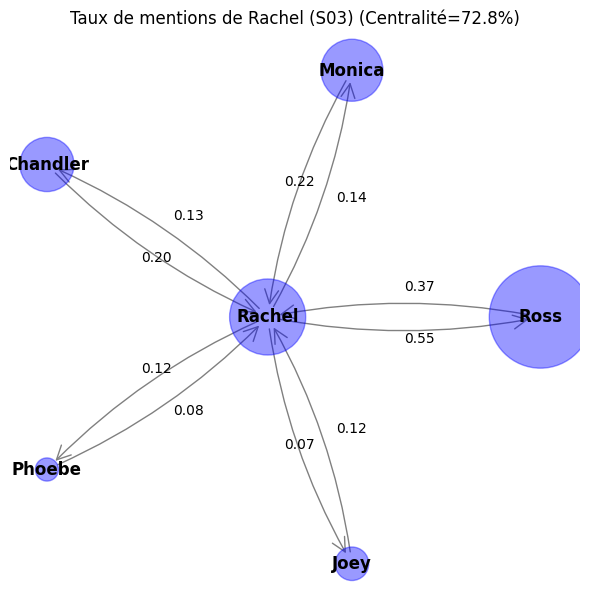

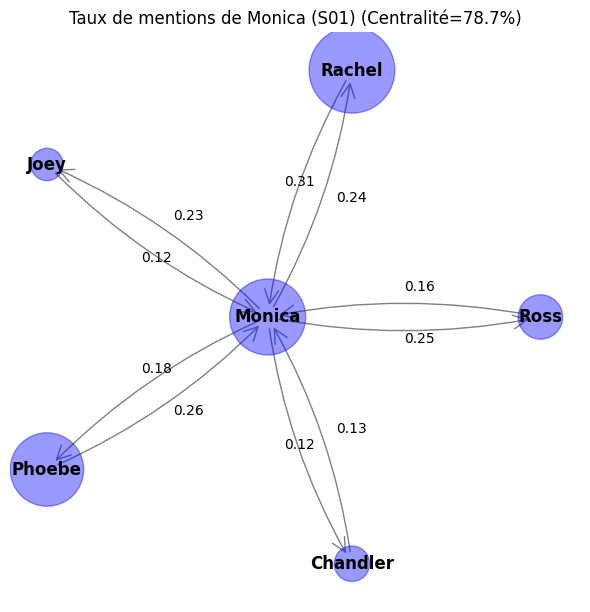

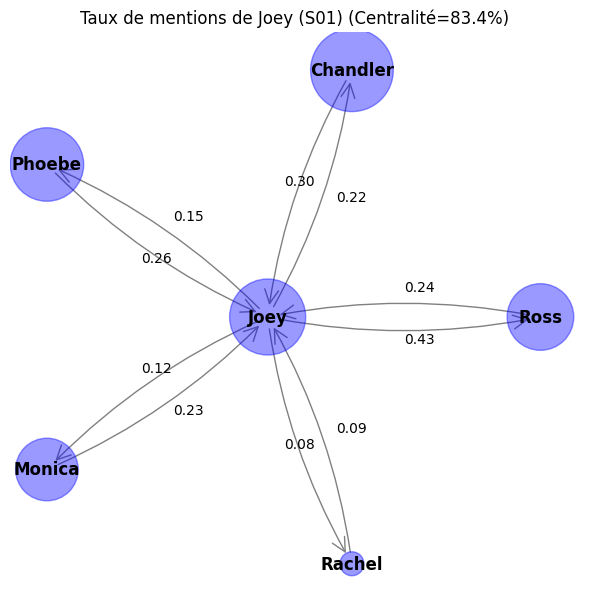

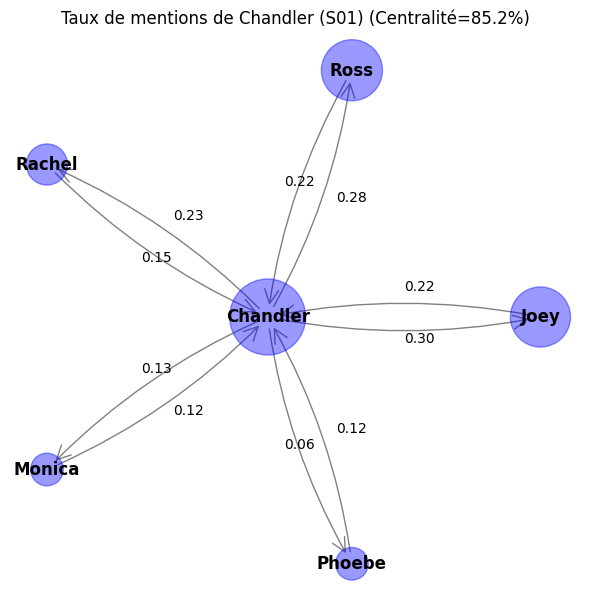

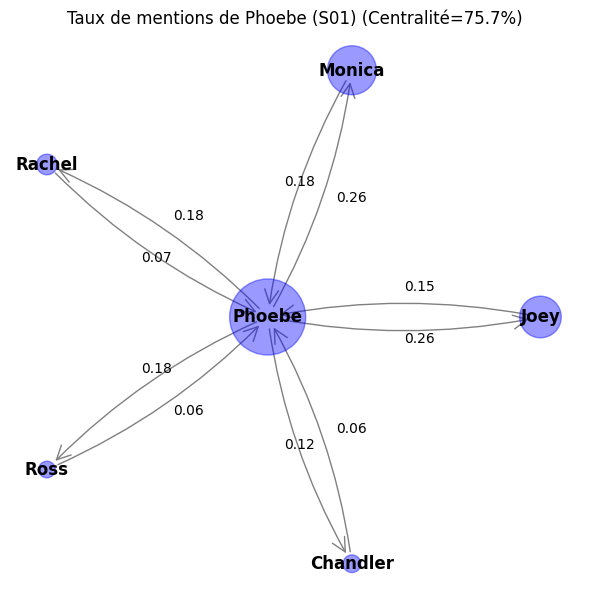

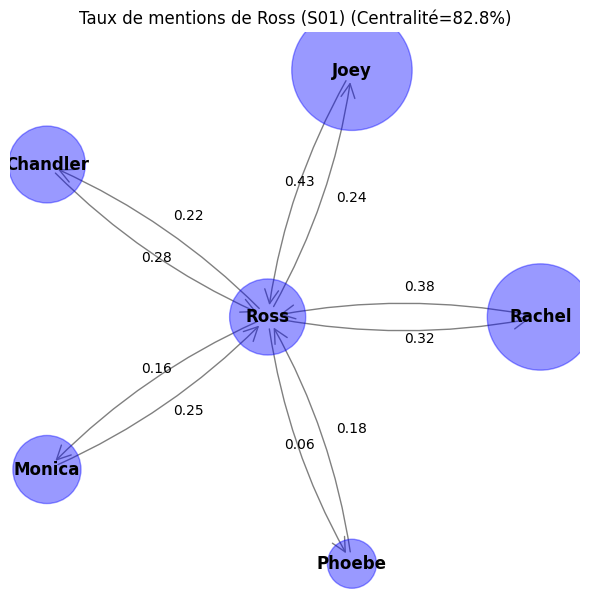

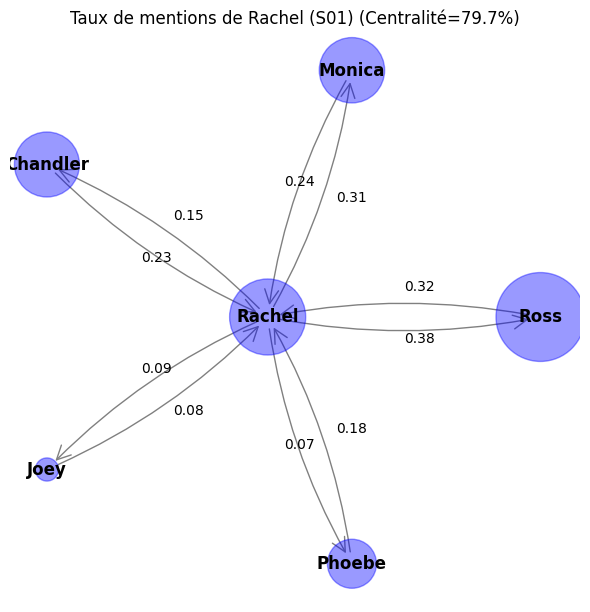

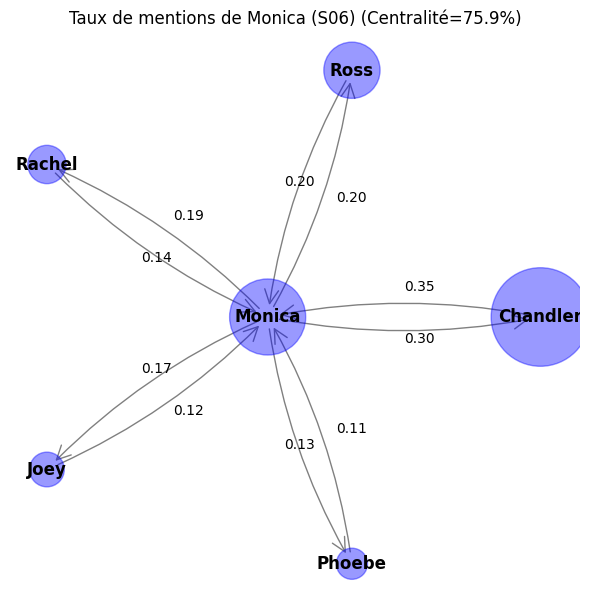

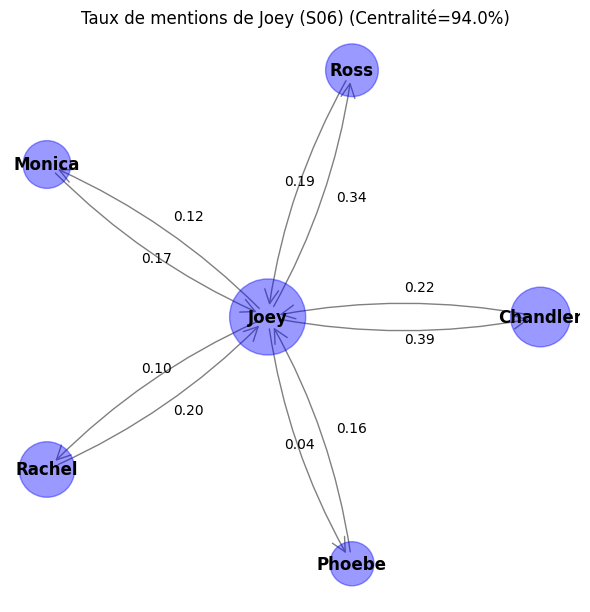

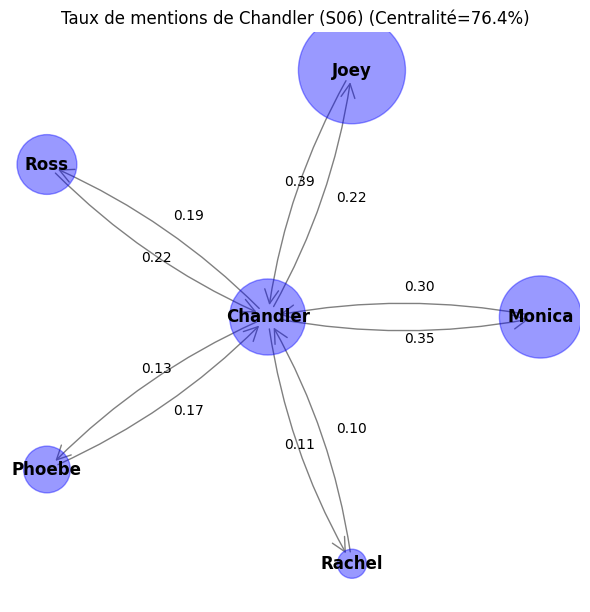

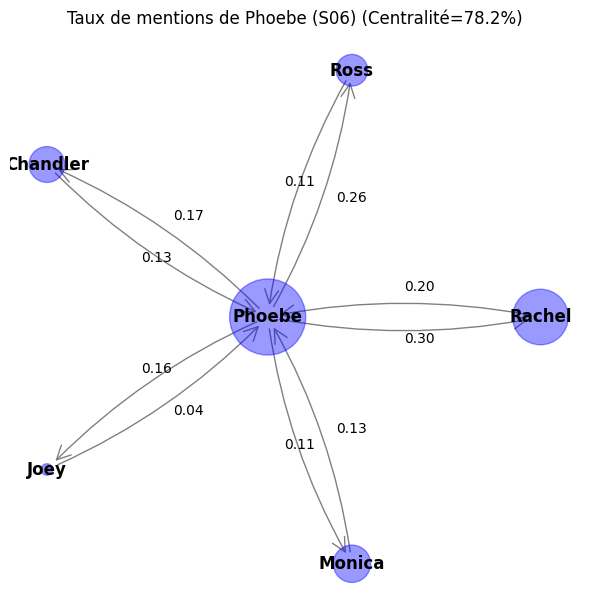

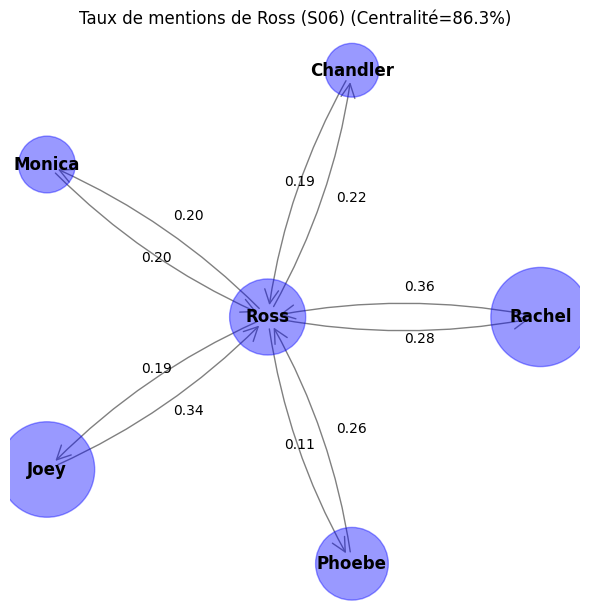

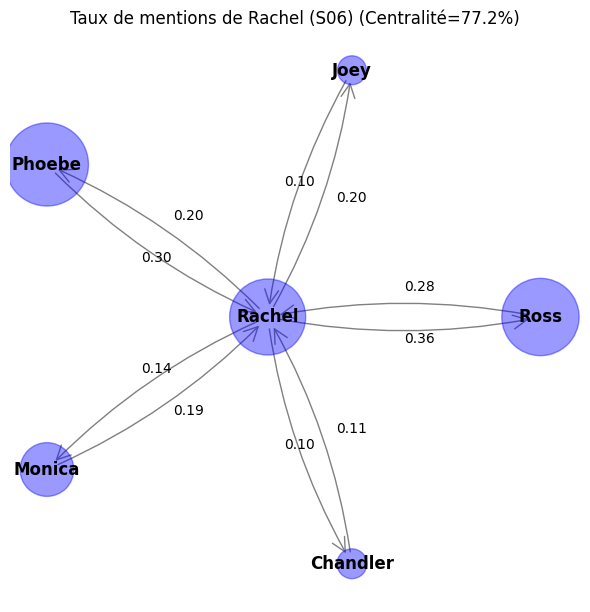

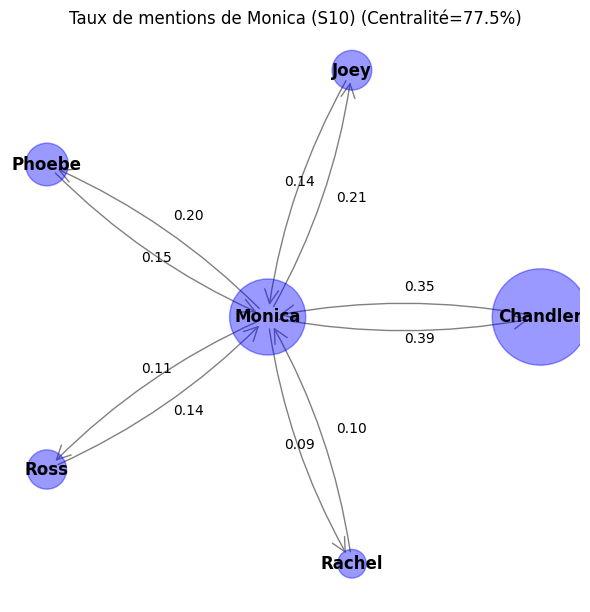

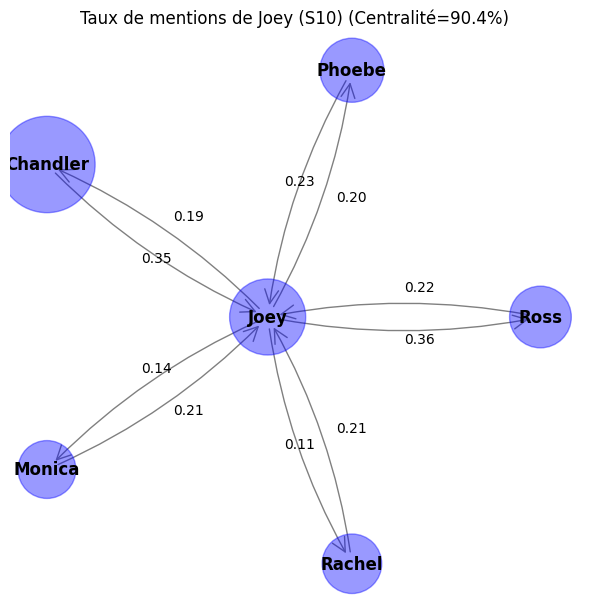

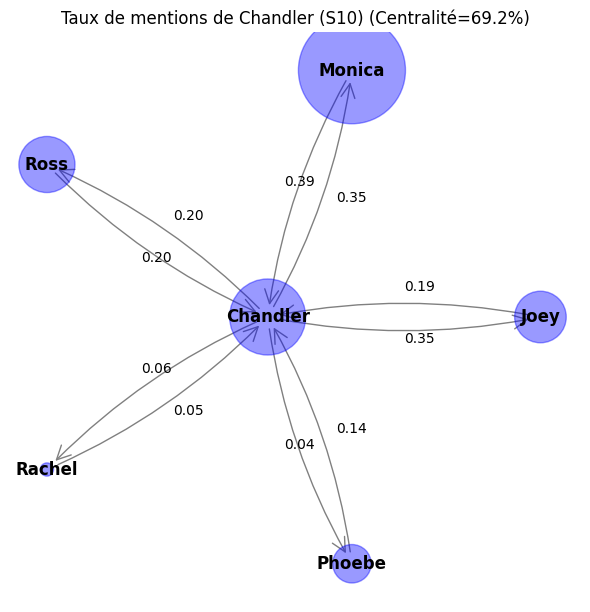

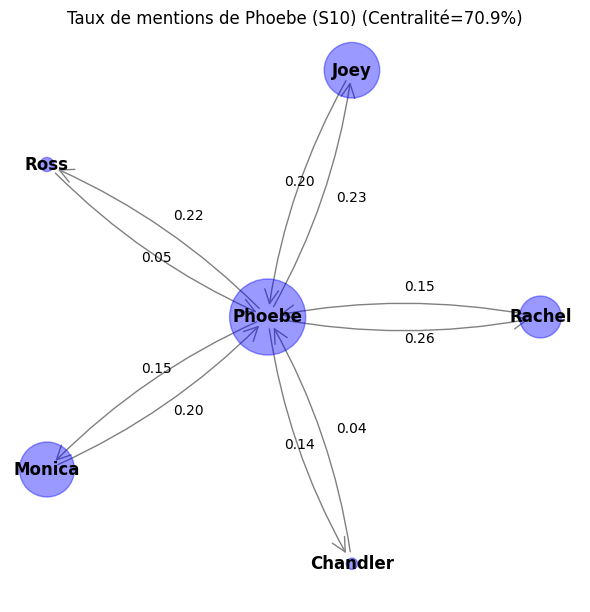

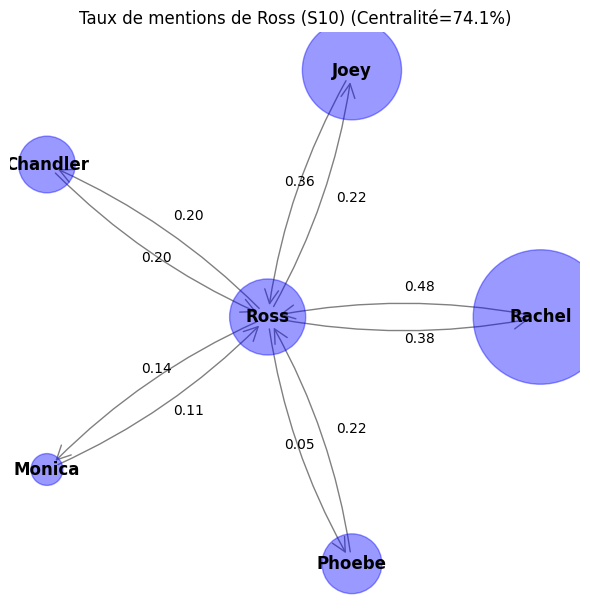

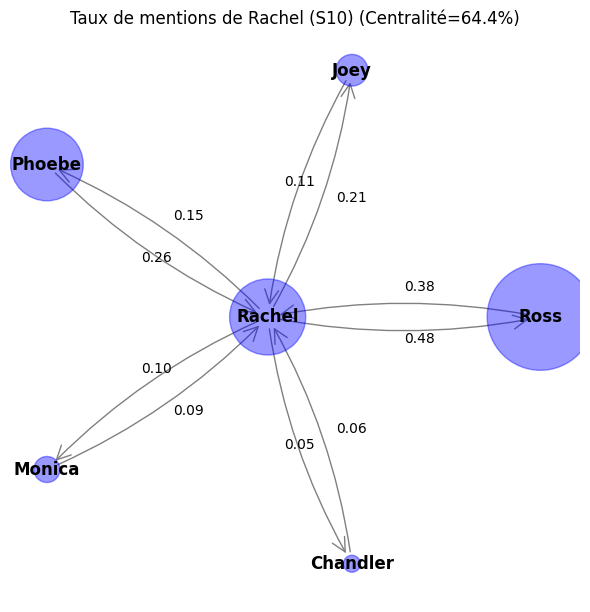

In [ ]:
def generer_graphe_des_6_persos_pour_une_saison(saison):
    mentions_by_character = { 'monica': [], 'joey': [], 'chandler': [], 'phoebe': [], 'ross': [], 'rachel': [] }

    # Etude des mentions entre personnages, qui mentionne le plus qui
    # Nettoyage + Filtre : on garde tous les mots étant des noms des 6 personnages principaux
    for _, row in df.iterrows():
        character = row['character'].lower()
        line = row['line']
        if (row['season'] == saison):
            if character in mentions_by_character:  # vérifier si le personnage est l'un des 6 principaux
                words = clean_line(line)  # nettoyer et diviser la ligne en mots
                mentioned_character = [word for word in words if word in mentions_by_character.keys()]
                mentions_by_character[character].extend(mentioned_character)  # Ajouter les mots au personnage

    mentions_stats = mentions_by_character.copy()
    for character, mentions in mentions_by_character.items():
        mention_counts = Counter(mentions) # compter les occurrences des mentions
        mention_counts[character] = 0
        mentions_stats[character] = mention_counts.most_common()  # récupérer les mots les plus fréquents (6)
    return mentions_stats

def generer_graph_oriente_de_mentions_pour_le_character(character, saison):
    plt.figure(figsize=(6, 6))
    G = nx.DiGraph() # graphe orienté

    mentions_dict = dict(mentions_stats[character])
    total_mentions_speaker = sum(count for pers, count in mentions_stats[character] if pers != character)

    for autre_character, nb_interactions in mentions_stats[character]:
        # on ignore les auto-mentions (un personnage qui se mentionne lui-même)
        if autre_character == character or nb_interactions == 0:
            continue

        poids_pondere = nb_interactions / total_mentions_speaker
        G.add_edge(character.capitalize(), autre_character.capitalize(), weight=poids_pondere)
        # Nombre de mentions de autre_character à ce character
        reverse_interactions = dict(mentions_stats.get(autre_character, []))
        # vérification si autre character a bien mentionné au moins une fois character
        if character in reverse_interactions and reverse_interactions[character] > 0:
            total_mentions_reverse = sum(count for pers, count in mentions_stats[autre_character] if pers != autre_character)
            poids_pondere_reverse = reverse_interactions[character] / total_mentions_reverse
            G.add_edge(autre_character.capitalize(), character.capitalize(), weight=poids_pondere_reverse)

    # Positionnement circulaire avec `character` au centre
    center_node = character.capitalize()
    edge_nodes = set(G) - {center_node}
    pos = nx.circular_layout(G.subgraph(edge_nodes))
    pos[center_node] = np.array([0, 0])

    node_weights = {}
    for node in G.nodes():
        if node == center_node:
            # taille fixe pour le centre, par ex. 3000
            node_weights[node] = 3000
        else:
            # somme des poids des arcs sortants (ou entrants) pour ce noeud
            node_weights[node] = sum(data['weight'] for _, _, data in G.out_edges(node, data=True))
    
    # Calcul taille des nœuds (ex: poids * 1000 sauf pour le centre)
    node_sizes = []
    for node in G.nodes():
        if node == center_node:
            node_sizes.append(node_weights[node])  # taille fixe
        else:
            node_sizes.append((node_weights[node] * 200) ** 2)  # taille proportionnelle


    # On dessine les nœuds et les labels
    nx.draw_networkx_nodes(G, pos, node_color='blue', alpha=0.4, node_size=node_sizes)
    nx.draw_networkx_labels(G, pos, font_weight='bold')

    # On dessine les arcs aller-retour du graphe orienté avec les mentions entre personnages
    for u, v in G.edges():
        # courbe si on a un arc aller-retour, sinon pas de courbe (dans notre graphe on est supposé avoir que des aller-retours)
        rad = 0.1 if (v, u) in G.edges else 0.0
        nx.draw_networkx_edges(
            G, pos, edgelist=[(u, v)],
            arrowstyle='->',
            arrowsize=25,
            connectionstyle=f'arc3,rad={rad}',
            edge_color='grey'
        )

    def calcul_label_coord(p1, p2, rad):
        """
        On veut placer le label X entre deux points p1 et p2
             X
           -----    
          /     \
        p1       >p2
        """
        # point milieu entre p1 et p2
        middle_p1p2 = (p1 + p2) / 2
        # vecteur directeur entre p1 et p2
        director_vector__p1p2 = p2 - p1
        # vecteur perpendiculaire/normal (pointe vers X (ci-dessus)) au vecteur directeur pour placer le label
        norm_vector_p1p2 = np.array([-director_vector__p1p2[1], director_vector__p1p2[0]])
        # Normalisation pour que le label ne soit pas loin de la flèche
        # optionnel dans ce cas précis -> grâce à circular_layout, tous les points sont à une distance (norme) de 1 au point central
        norm_vector_p1p2 = norm_vector_p1p2 / np.linalg.norm(norm_vector_p1p2)
        # Normalisation optionnel ici aussi
        curve = rad * np.linalg.norm(director_vector__p1p2)
        return middle_p1p2 + norm_vector_p1p2 * curve
    
    # affichage des poids près des flèches (personalisés car non implémenté dans networkx)
    label_deja_affiche = set()
    # a : par exemple le point Chandler
    # b : par exemple le point Ross
    # data : donnée contenant le nombre de mentions de Ross par Chandler
    for a, b, data in G.edges(data=True):
        # si une des deux flèches aller ou retour a déjà été traité alors
        if (a, b) in label_deja_affiche or (b, a) in label_deja_affiche:
            continue # ignorer, passer au tour suivant

        label_deja_affiche.add((a, b))

        # si il y a une flèche retour
        # dans notre graphe il y a que des flèches retours
        if (b, a) in G.edges:
            coord_label_fleche_retour = calcul_label_coord(pos[a], pos[b], 0.1)
            coord_label_fleche_aller = calcul_label_coord(pos[a], pos[b], -0.1)

            plt.text(coord_label_fleche_aller[0], coord_label_fleche_aller[1], f"{data['weight']:.2f}")
            plt.text(coord_label_fleche_retour[0], coord_label_fleche_retour[1], f"{G[b][a]['weight']:.2f}")
        # si il y a une simple flèche aller, cas impossible ici, notre graphe n'a que des flèches aller-retour, on traite en cas de problème
        else:
            coord_label_fleche = calcul_label_coord(pos[a], pos[b], 0)
            plt.text(coord_label_fleche[0], coord_label_fleche[1], f"{data['weight']:.2f}")

    centralite_gini = taux_equilibre([weight for char, weight in node_weights.items() if char != center_node])

    # suppression des axes (x, y), inutiles
    plt.axis('off')
    plt.tight_layout()
    plt.title(f"Taux de mentions de {character.capitalize()} ({saison}) (Centralité={round(centralite_gini, 1)}%)", fontsize=12)
    plt.savefig(f"{PATH}/mentions_{character}_{saison}.png", dpi=300, bbox_inches='tight')
    plt.show()

for season in df['season'].unique():
    # On génère un graphe orienté pour chaque personnage
    mentions_stats = generer_graphe_des_6_persos_pour_une_saison(season)
    for character in mentions_stats:
        # On génère un graphe orienté pour chaque personnage
        generer_graph_oriente_de_mentions_pour_le_character(character, season)
#mentions_stats = generer_graphe_des_6_persos_pour_une_saison('S06')

#for character in mentions_by_character:
# On génère un graphe orienté pour chaque personnage
    #generer_graph_oriente_de_mentions_pour_le_character(character, 'S06')

### NE SERT PLUS A RIEN

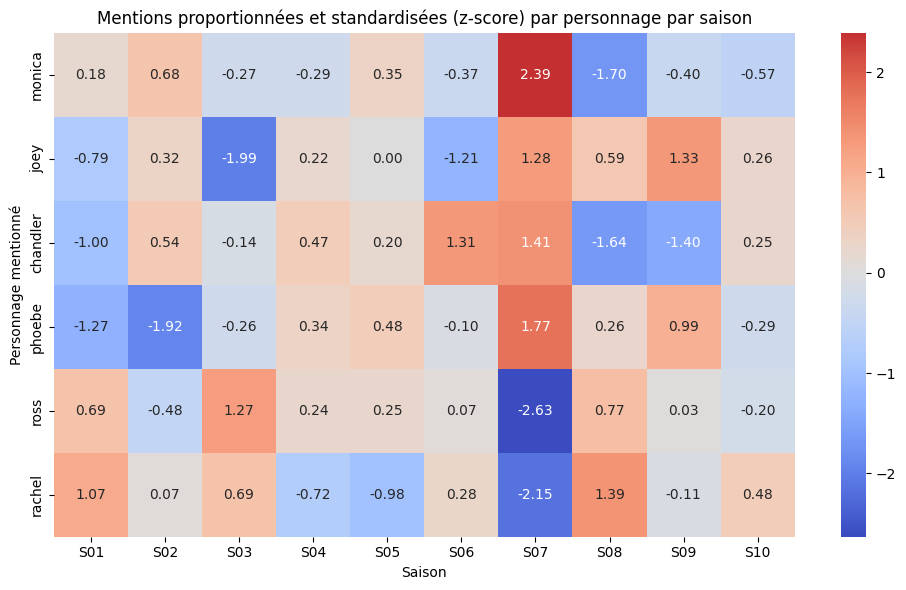

In [ ]:
# initialisation d'un DataFrame pour stocker les résultats
saisons = sorted(df['season'].unique())
characters = ['monica', 'joey', 'chandler', 'phoebe', 'ross', 'rachel']

mentions_per_season = pd.DataFrame(0, index=saisons, columns=characters)

# parcours des lignes pour compter les mentions par saison
for _, row in df.iterrows():
    saison = row['season']
    ligne = clean_line(row['line'])
    speaker = row['character'].lower()

    for mot in ligne:
        if mot in characters and mot != speaker:
            mentions_per_season.at[saison, mot] += 1

# total des répliques par saison
total_lines_per_season = mentions_per_season.sum(axis=1)

# normalisation par le total des répliques dans la saison
mentions_per_season_norm = mentions_per_season.div(total_lines_per_season, axis=0)

mentions_by_character = mentions_per_season_norm.T  # maintenant : index=character, colonnes=season

# normalisation par Z-score intra-personnage (par ligne)
mentions_zscore = pd.DataFrame(
    zscore(mentions_by_character, axis=1, nan_policy='omit'),
    index=mentions_by_character.index,
    columns=mentions_by_character.columns
).fillna(0)



# Heatmap avec z-score : mise en avant des personnages mentionnés beaucoup par rapport à leur autres saisons
plt.figure(figsize=(10, 6))
sns.heatmap(mentions_zscore, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Mentions proportionnées et standardisées (z-score) par personnage par saison")
plt.xlabel("Saison")
plt.ylabel("Personnage mentionné")
plt.tight_layout()
# sauvegarde en png :
#plt.savefig("mentions/zscore_all_mentions.png", dpi=300, bbox_inches='tight')
plt.show()

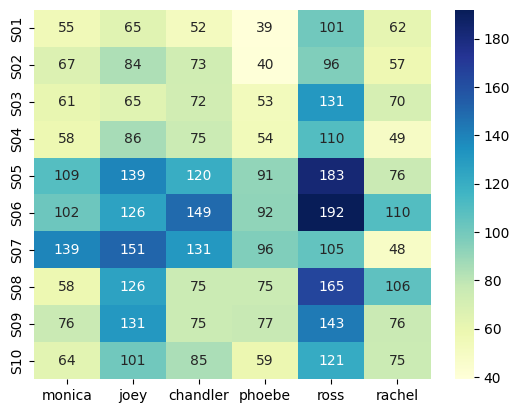

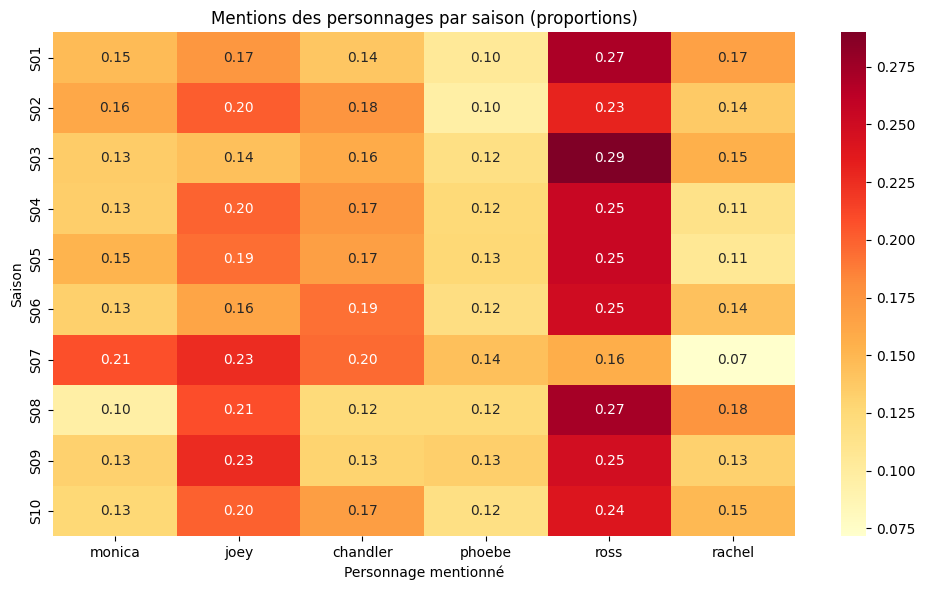

In [12]:
# Heatmap brute (nombre de mentions en fonction des personnages)
sns.heatmap(mentions_per_season, annot=True, cmap='YlGnBu', fmt='d')

# Heatmap proportionnelle en fonction des personnages (chaque saison fait un total de 1)
plt.figure(figsize=(10, 6))
sns.heatmap(mentions_per_season_norm.div(mentions_per_season_norm.sum(axis=1), axis=0), annot=True, cmap='YlOrRd', fmt=".2f")
plt.title("Mentions des personnages par saison (proportions)")
plt.xlabel("Personnage mentionné")
plt.ylabel("Saison")
plt.tight_layout()
plt.savefig("mentions/proportion_all_mentions.png", dpi=300, bbox_inches='tight')
plt.show()
